# Stacked Area Charts

One interesting thing you can do with line charts is use them to show how multiple elements of a thing change over the same period of time. The type of chart is called a Stacked Area chart, and there's two kinds -- ones that show the additive total, and ones that show the relative proportions within a population. Let's dive in, looking at a dataset of every prisoner in the Nebraska state corrections system. 

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
inmates <- read.csv("../../Data/inmateDB.csv", na.string = "NA")

In [3]:
head(inmates)

ID.NUMBER,COMMITTED.LAST.NAME,FIRST.NAME,MIDDLE.NAME,NAME.EXTENSION,LEGAL.LAST.NAME,FIRST.NAME.1,MIDDLE.NAME.1,NAME.EXTENSION.1,DATE.OF.BIRTH,⋯,PAROLE.ELIGIBILITY.DATE,EARLIEST.POSSIBLE.RELEASE.DATE,GOOD.TIME.LAW,INST.RELEASE.DATE,INST.RELEASE.TYPE,PAROLE.BOARD.NEXT.REVIEW.DATE.MONTH.YEAR.,PAROLE.BOARD.FINAL.HEARING.DATE.MONTH.YEAR.,PAROLE.BOARD.STATUS,PAROLE.DATE,PAROLE.DISCHARGE.DESC
1702,CLIFFORD,BRADLEY,,,,,,,,⋯,,,NA,1/6/1986,MANDATORY DISCHARGE,,,,,
6145,KANE,THOMAS,,,,,,,12/21/1928,⋯,6/20/1952,,2926,8/31/1952,ESCAPE,,,,,
6452,ATKINS,LARRY,,,,,,,7/26/1929,⋯,,,NA,7/20/1955,DISCRETIONARY PAROLE,,,PAROLED,12/9/1980,EARLY DISCHARGE BY PAROLE BRD
12444,SHANEYFELT,CHARLEY,,,,,,,4/10/1905,⋯,,,NA,12/24/1987,MANDATORY DISCHARGE,,,,,
15379,BEADES,JOE,,,,,,,10/12/1924,⋯,5/2/1955,LFE,2926,7/19/1989,DISCRETIONARY PAROLE,,,PAROLED,1/17/1993,EARLY DISCHARGE BY PAROLE BRD
15410,WILSON,JOHN,,,,,,,,⋯,5/28/1945,,2926,3/13/2003,OTHER,,,,,


So what we want is to take this data and group it by race and the year they started their sentence. We've carved out years using date formatting. Let's try a new way -- using `tidyr` and `separate`. 

Sometimes, you want to split a field into multiple fields based on a common separator -- like a slash or a comma or something like that. The [`separate`](http://tidyr.tidyverse.org/reference/separate.html) function lets you separate that data and name the fields at the same time. So, in our case, we want to split a date based on a slash. So we'll create Day, Month and Year and split it on the slash. Then, we'll group our data by Year and RACE.DESC and count it up. You'll also notice there's a filter in the data -- data before 1980 is pretty spotty and there's a couple of typos where people won't start their sentences for quite some time into the future. 

In [4]:
raceyear <- inmates %>%
    separate(SENTENCE.BEGIN.DATE, c("Day", "Month", "Year"), "/", convert = TRUE) %>%
    filter(Year >= 1980 & Year <= 2017) %>%
    group_by(Year, RACE.DESC) %>%
    summarize(
       count=n()
    )

Warning message:
“Too few values at 1472 locations: 1, 6268, 7302, 30000, 32284, 33668, 43259, 56120, 56165, 56810, 56813, 56828, 56829, 56831, 56843, 56851, 60064, 60308, 60354, 64359, ...”

Now, if we use similar ggplot setup to what we've used before and add `geom_area()` to our toolbox, we get the following:

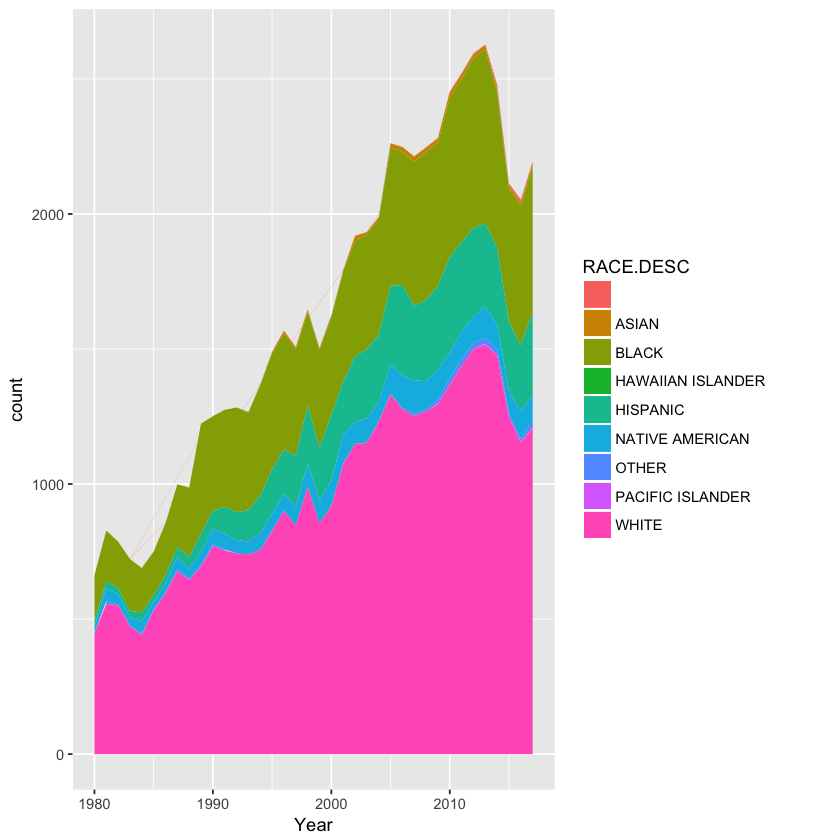

In [5]:
ggplot(raceyear, aes(x=Year, y=count, fill=RACE.DESC)) +
    geom_area()

Let's add a new trick, and that's renaming the legend title. We'll also add some other labelling here for good practice. [Here's the documentation on what you can do with legends in ggplot](http://www.cookbook-r.com/Graphs/Legends_(ggplot2)/).

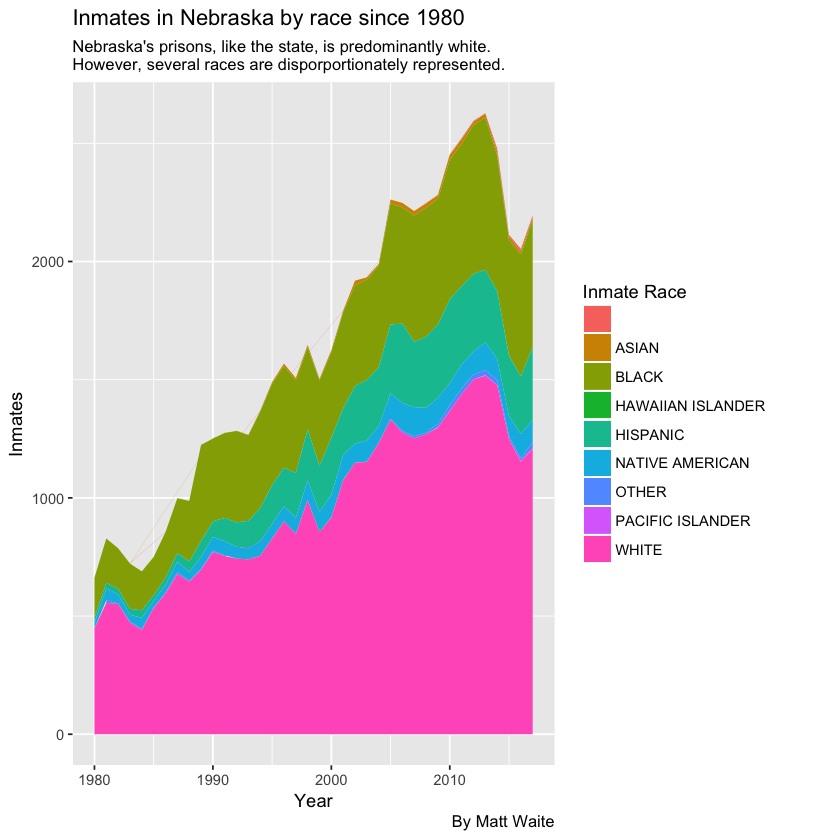

In [14]:
ggplot(raceyear, aes(x=Year, y=count, fill=RACE.DESC)) +
    geom_area() + scale_fill_discrete(name="Inmate Race") + 
    labs(x="Year", y="Inmates", title="Inmates in Nebraska by race since 1980", subtitle="Nebraska's prisons, like the state, is predominantly white. \nHowever, several races are disporportionately represented.", caption="By Matt Waite")

That shows you the race of inmates by their start date, stacked onto each other, which shows you the breakdown of the total over time in a visual way. But what if we wanted to see the relative proportion? And we wanted the graph to show the total?

## Introducing joins in dplyr

So to get the percentage of what a particular race represented among inmates for a given year, we need two pieces of information: The count of that race for that year, and the total number of inmates for that year. Since we have no way to do this in one step, we're going to have to merge two datasets together -- called a join in databases, and also in dplyr. 

So similar to what we did before, here's the code needed to just create a count of inmates by year. NOTE: I just edited my previous code, so it was created the same way as the race counts were created. I just altered some variable names and only grouped by year. 

In [7]:
yeartotals <- inmates %>%
    separate(SENTENCE.BEGIN.DATE, c("Day", "Month", "Year"), "/", convert = TRUE) %>%
    filter(Year >= 1980 & Year <= 2017) %>%
    group_by(Year) %>%
    summarize(
       count=n()
    )

Warning message:
“Too few values at 1472 locations: 1, 6268, 7302, 30000, 32284, 33668, 43259, 56120, 56165, 56810, 56813, 56828, 56829, 56831, 56843, 56851, 60064, 60308, 60354, 64359, ...”

Now we can join the two datasets we've created together -- `raceyear` and `yeartotals`. The way joins work is there must be a common element between them to join them together. If you look at our two datasets, both have a Year element that is common between them. So we'll use that. 

In [8]:
percents <- raceyear %>% 
    inner_join(yeartotals, by="Year") %>%
    mutate(percentage = (count.x/count.y)*100)

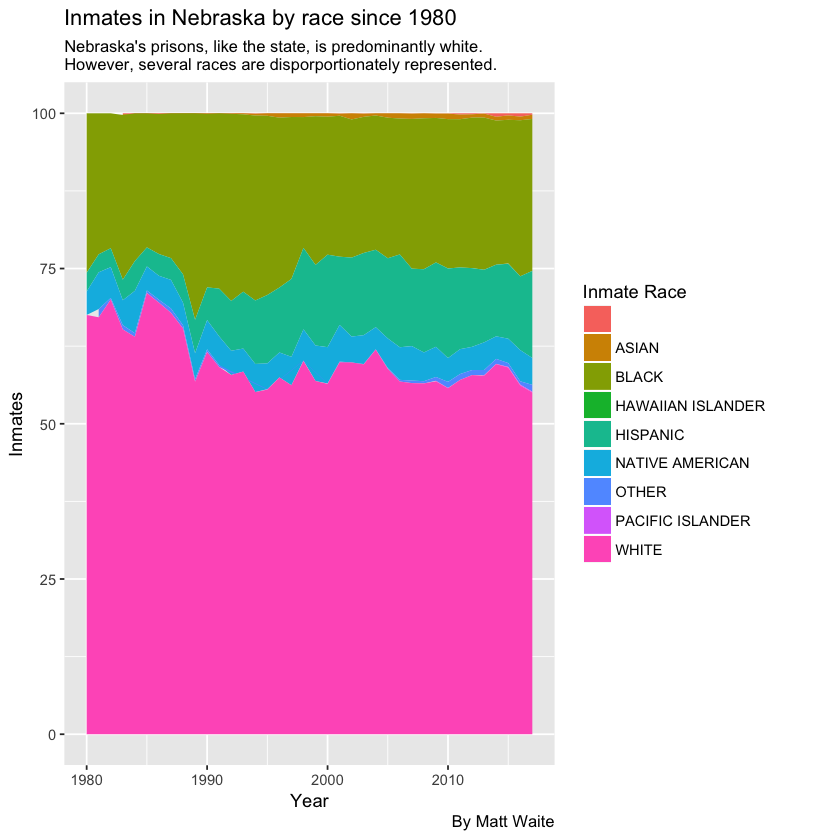

In [16]:
ggplot(percents, aes(x=Year, y=percentage, fill=RACE.DESC)) +
    geom_area() + scale_fill_discrete(name="Inmate Race") + 
    labs(x="Year", y="Inmates", title="Inmates in Nebraska by race since 1980", subtitle="Nebraska's prisons, like the state, is predominantly white. \nHowever, several races are disporportionately represented.", caption="By Matt Waite")

## Assignment

Time to stretch your thinking a little. Using a stacked area chart, I want you to show me the proportions of drug possession and minor in possession calls are to the total call volume at UNL by month. You'll use the same UNLPD data you've had, but you are going to have to figure out how to handle the dataset. There's multiple solutions here, and several questions for you to ponder -- like how do you deal with so many different crimes? Can you chart them all? Should you? 

I expect this to challenge you, so the deadline is in one week. While it will challenge you, it is also a critical element of the class. You'll soon be obtaining data and having to make these decisions on how to best visualize the data without the benefit of a rubric or my guidance.

### Rubric
1. Did you import the data correctly?
2. Did you manipulate the data correctly?
3. Did you chart the data?
4. Did you change the labels correctly and produce the required charts?
5. Did you explain your steps in Markdown comments?